## A toy model for exploring the theory behind various enhanced sampling methods.

Let's do some imports!

In [2]:
import numpy as np
import numpy.random
import scipy
import matplotlib.pyplot as plt
import pymbar

In order to discuss enhanced sampling, we need to have a potential energy surface we want to explore.  We'll start with the simplest case; two minima in one dimension. Think: how would this be harder in multiple dimensions?

In [3]:
#define the potential - these can be altered.
mean1 = 1.0  # center of first minima
mean2 = 9.0  # center of 2nd minima
cut1 = 4.0   # start of transition region
cut2 = 6.0   # end of transition region
const1 = 0.0  # value at bottom of  first minima
const2 = -2.0 # value at bottom of second minima - it's lower!
barrier = 60.0 # the value at (cut1+cut2)/2   # Barrier height
k1 = 5 # spring contstant of first minima
k2 = 5 # spring constant of 2nd minima

def lower_pot(x):
    pot = k1*(x-mean1)**2 + const1  # Harmonic!
    return pot

def upper_pot(x):
    pot = k2*(x-mean2)**2 + const2  # Harmonic!
    return pot

def interpolate_pot(x):  # smooth interpolation between the two minima
    x1 = cut1
    x2 = cut2
    x3 = (cut1+cut2)/2
    y1 = lower_pot(cut1)
    y2 = upper_pot(cut2)
    y3 = barrier
    # lagrange interpolation formula for a smooth potential barrier is
    return y1*(x-x2)*(x-x3)/((x1-x2)*(x1-x3)) + y2*(x-x1)*(x-x3)/((x2-x1)*(x2-x3)) + y3*(x-x1)*(x-x2)/((x3-x1)*(x3-x2))

def potential(x):
    # define it as a piecewise potential to make it possible to vectorize.
    return np.piecewise(x,[x<cut1,x>cut2],[lower_pot,upper_pot,interpolate_pot])

Now let's plot this potential!

(-2.0, 12.0)

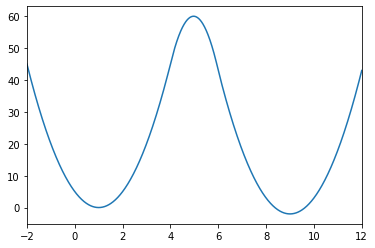

In [5]:
x = np.linspace(-2,12,1000)
plt.plot(x,potential(x))
plt.xlim([-2,12])

We've talked about how important the probability distribution is to look at. So, what does the probability distribution look like at different temperatures? Since we are also interested in ensemble average properties, we'll look at the average energy as a function of temperature for our system.

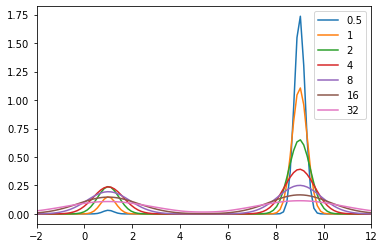

T =  [0.5, 1, 2, 4, 8, 16, 32]
Average energy E[T] = [-1.71402758 -1.26159416 -0.46211716  0.75509062  2.88124067  6.95295316
 13.87973719]
Free energy    F[T] = [ -1.71961116  -1.894574    -2.85496253  -5.73948133 -13.06736749
 -30.60585194 -70.98259426]


In [101]:
#Temps = [0.5,1,5,20]
Temps = [0.5,1,2,4,8,16,32]
Es = np.zeros(len(Temps))
Fs = np.zeros(len(Temps))
for i,T in enumerate(Temps):
    # determine the normalizing constant - very important!  in 1D, easy to do by numerical integration
    Q = scipy.integrate.quad(lambda x: np.exp(-potential(x)/T),-10,20)[0]
    # and calculate the free energy
    Fs[i] = -T*np.log(Q)
    # let's calculate the average energy as a function of temperature: again, an integral.
    Es[i] = scipy.integrate.quad(lambda x: potential(x)*np.exp(-potential(x)/T),-10,20)[0]/Q
    #now plot the probability distribibution at different temperatures
    plt.plot(x,np.exp(-potential(x)/T)/Q,label=T) # we set k_B =1; we don't care about specific units.
plt.xlim([-2,12])
plt.legend()
plt.show()
print('T = ',Temps)
print('Average energy E[T] =',Es)
print('Free energy    F[T] =',Fs)

In [ ]:
array([-1.69440461, -1.13727372, -0.24276101,  1.01730025,  3.17610002,
         7.19682653, 13.45953105])

We see that at low temperatures, it's pretty much always in the lowest well (at 9), and so the average energy is close to -2.  At higer temperatures, it's in both wells, and at high temperatures, it spends some of it's time everywhere, with a much higher average energy. Play around with some different temperatures!

## Sampling a potential energy surface with Markov Chain Monte Carlo

We'll define Markov Chain Monte Carlo on this system, using the Metropolis-algorthim. We could do MD, but it's a bit more complicated, since we have to keep track of momenta, etc.  We want to keep it relatively simple.

In [8]:
def MCstep_1D(xold,T,potential):

    newstep = np.random.normal()  # a symmetric (in this case, Gaussian) proposal to move up and down.
                                  # The default standard deviation is 1 unit, which seems resonable for the 
                                  # size of the well; 1-2 steps may be needed to move out of the minima
    xnew = xold+newstep  # move a little bit. 
    oldp = potential(xold)  # calculate the old potential
    newp = potential(xnew)  # calculate the new potential
    
    if newp < oldp:  # if the energy is lower, move!
        return xnew
    else:  # if the energy is higher, we have to compute a probability of moving.
        if np.random.random() < np.exp(-(newp-oldp)/T):
            return xnew 
        else:
            return xold
    # in either case, return the next location - which is either the same as the old one, or a new location. 

Now let's simulate this system!

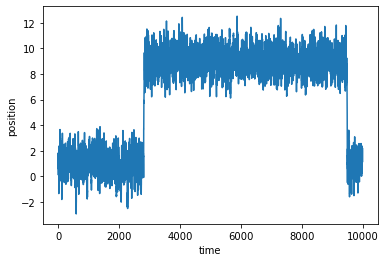

In [21]:
ntraj = 10000  # number of steps to take
T = 10 # set the temperature

xtraj = np.zeros(ntraj)
xtraj[0]=1.0  # set the initial position
for i in range(ntraj-1):
    xtraj[i+1] = MCstep_1D(xtraj[i],T,potential)
    
# now plot the trajectory over time.    
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

Let's look at histogram of where the system is.

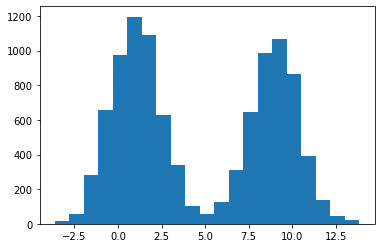

In [17]:
plt.hist(xtraj,bins=int(ntraj**(1/3)))
plt.show()

Let's calculate the average energy! Does this seem right?

In [22]:
# recalculating all of the energies of each configuration with the potential we created.
energies = potential(xtraj)  


In [23]:
print(np.mean(energies))

3.8032966810724886


How about running it at other temperatures? What happens? What happens when you start at different locations?

## Trying some enhanced sampling concepts
We want to escape from a potential energy minimum, and get to other, hopefully lower free energy (higher probability) minima.  But in a way that allows us to preserve the proper distribution! 

### Idea 1: Could we add a potential that partly cancels the barriers out?

In [235]:
def biased_potential(x):
    # if its OUTSIDE x=11 or x<-1, return the potential
    # if it's inside, return 0 - we are exactly removing the potential
    return (np.logical_or(x>11, x<-1)) * potential(x)

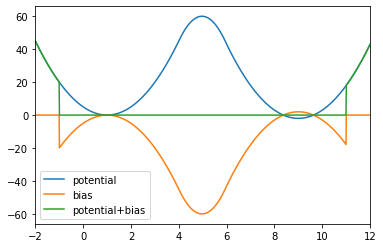

In [236]:
x = np.linspace(-2,12,1000)
plt.plot(x,potential(x),label='potential')
plt.plot(x,biased_potential(x)-potential(x),label='bias')
plt.plot(x,biased_potential(x),label='potential+bias')
plt.legend()
plt.xlim([-2,12])
plt.show()

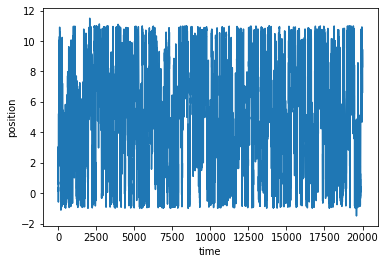

In [237]:
ntraj = 20000  # number of steps to take
T = 5 # set the temperature

xtraj = np.zeros(ntraj)
xtraj[0]=1.0  # set the initial position
for i in range(ntraj-1):
    xtraj[i+1] = MCstep_1D(xtraj[i],T,biased_potential)
    
# now plot the trajectory over time.    
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

Can we _reweight_ to find the correct averages?  Recall, weights from importance sampling are of the form $\frac{p_j(x)}{p_i(x)}$, where $j$ is the state we care about and $i$ is the state we are actually sampling from. For the Boltzmann distribution, this is equal to $e^{A_j-U_j(x)} / e^{A_j-U_j(x)} = e^{\Delta A - \Delta U_j(x)}$.

So first, we need to calculate the energies of our simulation with the potential we care about - not the biased one, the original one.


In [240]:
energies = potential(xtraj)

Clearly, the average energy itself is not very useful!  Let's look at the weighted average.

In [241]:
np.mean(energies)

17.394265088270195

We then would need to calculate the free energy difference between the two states to get normalized probabilities right. Recall the free energy formula is $\Delta A = -k_B T \ln \frac{1}{N} \sum_i e^{-(U_j(x) - U_i(x))}$

In [242]:
dA = -T*np.log(np.mean(np.exp(-energies/T)))
print(dA)

4.968336985296254


In [243]:
#The weights are of the form: p_j/p_i, where p_j is the state we care about, and is the state we sampled fom
# w = exp(dA-dU)
weights = np.exp((dA-energies)/T)

The weights should sum up to the same number of samples we had to start with. 

In [244]:
np.sum(weights)

20000.000000000004

In [245]:
# OK let's calculate the weighted average
np.mean(weights*energies)

1.255478015775333

That's pretty darn close for that $T$ (analytically, it's  1.303). How does it do that?  Let's look at the weights a bit more.

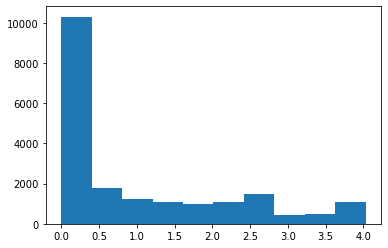

In [246]:
plt.hist(weights)
plt.show()

How many are above 0.1? What does that mean for weights to be very small or very large?

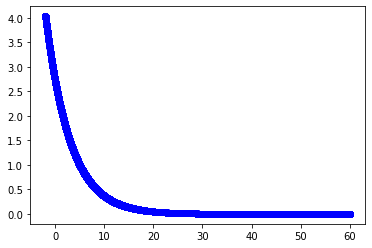

In [250]:
plt.plot(energies,weights,'bo')
plt.show()

We see small energy differences get large weights, big energy differences get small weights!

QUESTION: How might this process be harder in a multidimensional space?

### Idea 2: Define some auxiliary ("helper") potentials that bridge the gap between minima.

In [41]:
def ip(c1,c2,n,i):
    # linearly iterpolate between two parameters c1 and c2, in n steps, 
    # returning the ith step along the interpolation.
    # when i=0, it's c1
    # when i=n, it's c2
    return c1*(n-i)/n + c2*(i/n)

In [251]:
nstates = 5
potentials = []
potentials.append(potential)
for i in range(1,nstates):
    potentials.append(lambda x, i=i: ip(k1,k2,nstates,i)*((x-ip(mean1,mean2,nstates,i))**2) + ip(const1,const2,nstates,i))

Let's plot these potentials, along with the original one.

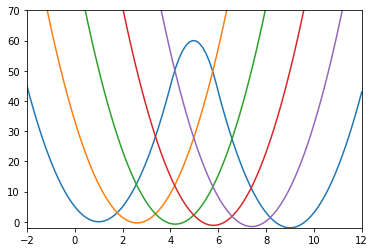

In [252]:
x = np.linspace(-2,12,100)
for p in potentials:
    plt.plot(x,p(x))
plt.xlim([-2,12])
plt.ylim([-2,70])
plt.show()

A new idea: Let's do Monte Carlo BETWEEN states (potentials).

These are not physical states, these are artificial states - but we are using a computer, who cares?
1. Pick a random other state (symmetric!)
2. Use the Metropolis criteria to decide to go up or down.

Define our MC state step:

In [44]:
def MCstep_2D_state(x,iold,T,potentials):

    inew = iold
    while (inew == iold):
        inew = np.random.randint(0,len(potentials))  # jump to any random state that's not the current state

    oldp = potentials[iold](x)
    newp = potentials[inew](x)
    
    if newp < oldp:  # if the energy is lower, move
        return inew
    else:
        if np.random.random() < np.exp(-(newp-oldp)/T):
            return inew
        else:
            return iold

Now here is our algorithm; 50% of the time do a state move, 50% do a coordinate move.

In [56]:
ntraj = 20000
T = 1.0
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]= 1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_1D(xtraj[i],T,potentials[itraj[i]])
        itraj[i+1] = itraj[i]
    else:   # and half the time, do a state move
        itraj[i+1] = MCstep_2D_state(xtraj[i],itraj[i],T,potentials)
        xtraj[i+1] = xtraj[i]

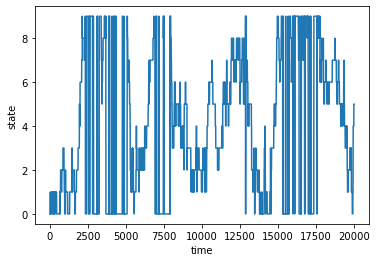

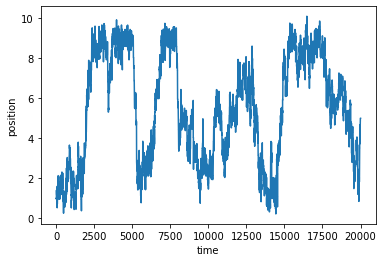

In [57]:
# let's plot the trajectory - which is now 2D!
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

Let's look at the distributions of each state. Remember, the potential we want to sample is the blue one.

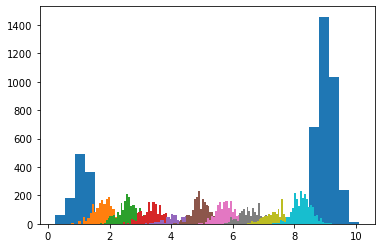

In [58]:
for i in range(len(potentials)):
    plt.hist(xtraj[np.where(itraj==i)],bins=30)
plt.show()

**ACTIVITY**: What is the average potential energy of the state we are interested in? 

In [64]:
np.mean(potential(xtraj[np.where(itraj==0)]))

-1.0605437647432328

### Idea 3: Let's take the existing potential, but add a bias that that "carries'' it from one minimum to another as the bia varies.

Above, we "morphed" the potential to introduce new states.  We can't always guess totally new potentials that can help morph between minima (why not?).  But we **can** add an extra potential that localizes the probability.

In [211]:
nsteps = 10
umbrella_potentials = []
umbrella_potentials.append(potential)
for i in range(1,nsteps):
    # for each potential, we add a harmonic well that gradually moves across the system
    # We'll leave off the constant, since maybe we don't KNOW the constant yet.
    umbrella_potentials.append(lambda x, i=i: potential(x) + ip(k1,k2,nsteps,i)*((x-ip(mean1,mean2,nsteps,i))**2))

Now, let's plot the potential with the different biases

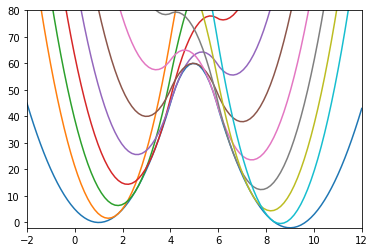

In [212]:
x = np.linspace(-2,12,100)
for p in umbrella_potentials:
    plt.plot(x,p(x))
plt.xlim([-2,12])
plt.ylim([-2,80])
plt.show()

In [213]:
ntraj = 50000
T = 5
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_1D(xtraj[i],T,umbrella_potentials[itraj[i]])
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_state(xtraj[i],itraj[i],T,umbrella_potentials)
        xtraj[i+1] = xtraj[i]

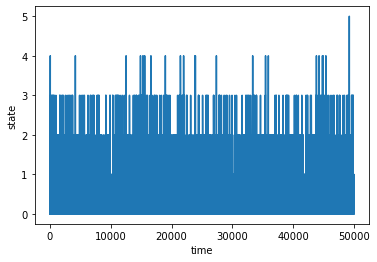

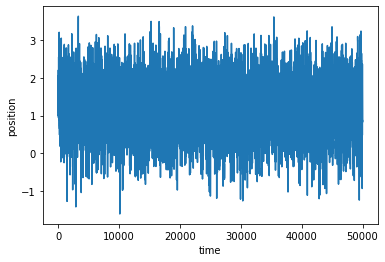

In [214]:
# let's plot the trajectory
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

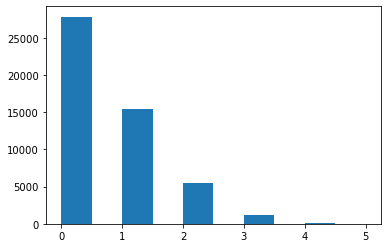

In [215]:
plt.hist(itraj)
plt.show()

We need to change the potential some more - we need to make the intermediate states lower in energy.  
Note that this is the same as changing the _free energy_ of the intermediate states.  Let's guesstimate. 

In [229]:
nsteps = 10

weights = [  0.        ,  -4.66063784,  -9.9029834 , -18.39320369,
       -30.16072853, -42.95954776, -33.93449478, -23.03937484,
       -15.38695201, -11.05005677]

wumbrella_potentials = []  # weighted umbrella potentials
wumbrella_potentials.append(potential)
for i in range(1,nsteps):
    wumbrella_potentials.append(lambda x, i=i: potential(x) + weights[i]+ ip(k1,k2,nsteps,i)*((x-ip(mean1,mean2,nsteps,i))**2) + ip(const1,const2,nsteps,i))

Plot the potentials:

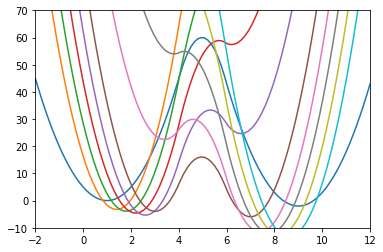

In [230]:
x = np.linspace(-2,12,100)
for p in wumbrella_potentials:
    plt.plot(x,p(x))
plt.xlim([-2,12])
plt.ylim([-10,70])
plt.show()

Now run with MC in both distance and state

In [231]:
ntraj = 100000
T = 5
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_1D(xtraj[i],T,wumbrella_potentials[itraj[i]])
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_state(xtraj[i],itraj[i],T,wumbrella_potentials)
        xtraj[i+1] = xtraj[i]

Let's plot the trajectory (in both dimensions):

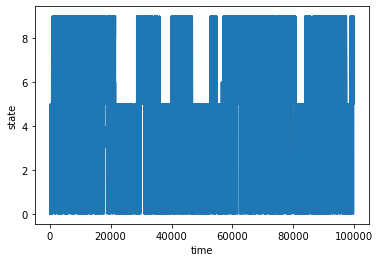

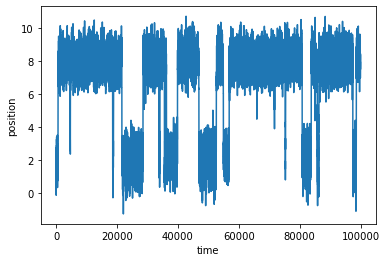

In [232]:
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

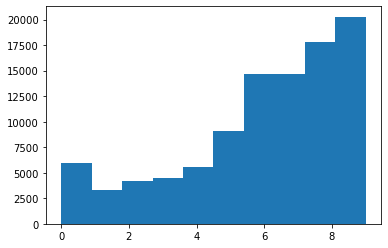

In [233]:
plt.hist(itraj)
plt.show()

How can we do better than this?  What are our choices?  We need to adjust our free energies. How could you calculate the free energies simply?

QUESTION: How would this process work in many dimensions?

### Idea 3a.  Umbrella sampling: 
Another alternative to find the weights is to carry out individual simulations of each of the potentials with localizing biases, and calculate the free energies from that information.

In [222]:
## umbrella sampling

#Let's carry out simulations of each umbrella, in turn (put it all in the same trajectory)
npots = len(umbrella_potentials)
nstage = 3000
T = 5
xtraj = np.zeros(nstage*npots)
xtraj[0]=1.0
n=0
for p in wumbrella_potentials:
    for i in range(nstage):
        if n+1<nstage*npots:
            xtraj[n+1] = MCstep_1D(xtraj[n],T,p)
            n=n+1

Let's plot the "trajectory"


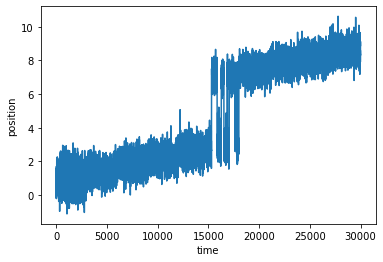

In [223]:
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

To do multistate reweighting, we need potential energy of each sample in each of the other potentials.

In [224]:
ntraj = len(xtraj)
energies = np.zeros([len(wumbrella_potentials),len(xtraj)])
for j in range(nsteps):
    energies[j,:] = umbrella_potentials[j](xtraj)
energies = energies/T

In [225]:
print(np.shape(energies))

(10, 30000)


In [226]:
# count the number of samples at each T 
N_k = nstage*np.ones(len(umbrella_potentials))
print(np.shape(N_k))

(10,)


In [227]:
# use pymbar to do the multistate reweighing to find the free energies.
mbar=pymbar.MBAR(energies,N_k,verbose=True) 
results = mbar.compute_free_energy_differences()
results['Delta_f'][:,0]*5 # pymbar returns nondimensional, need to multiply by T to get free energies.

array([  0.        ,  -4.66063784,  -9.9029834 , -18.39320369,
       -30.16072853, -42.95954776, -33.93449478, -23.03937484,
       -15.38695201, -11.05005677])

Now, try these free energies above as the weights in idea 3 above . . . 

**Challenge**: How would you calculate the expectations of the observables in the original potential? Come back to this after Idea 4.

### Idea 4: How about running at set of different temperatures?

Let's try at simulation that bounced between different temperatures, BUT still preserves the distributions.  We will need to redefine state move!

In [191]:
def MCstep_2D_stateT(x,iold,Ts,potential):

    newstep = np.random.randint(0,len(Ts))  # jump to any random state - this is symmetric!
    inew = newstep
    pot = potential(x)
    oldPT = pot/Ts[iold]
    newPT = pot/Ts[inew]
    
    if newPT < oldPT:  # if the energy is lower, move
        return inew
    else:
        if np.random.random() < np.exp(-(newPT-oldPT)):
            return inew
        else:
            return iold

In [192]:
ntraj = 50000
Ts = [0.5,1,2,4,8,16,32]
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # 50% of the time, do a coordinate move
        xtraj[i+1] = MCstep_1D(xtraj[i],Ts[itraj[i]],potentials[0])
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_stateT(xtraj[i],itraj[i],Ts,potentials[0])
        xtraj[i+1] = xtraj[i]

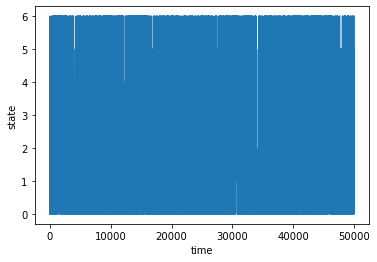

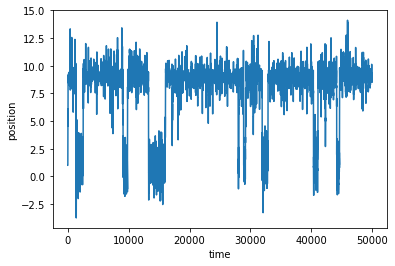

In [193]:
# let's plot the trajectory
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

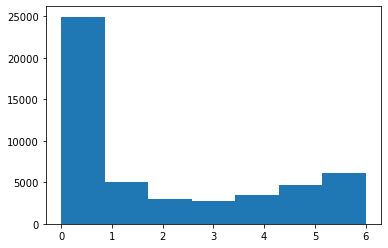

In [194]:
plt.hist(itraj,bins=len(Ts))
plt.show()

In [195]:
energies = potentials[0](xtraj)

Let's try to calculate the expectations in energy at each temperature, using mixture reweighting. 

In [196]:
#rescaled energies for pymbar
reduced_energies = np.zeros([len(Ts),len(xtraj)])
for i,T in enumerate(Ts):
    reduced_energies[i,:] = energies/T

In [197]:
N_k = np.zeros(len(Ts))
for i in range(len(Ts)):
    N_k[i] = (itraj==i).sum() # count how many samples there are at each temperature
print(N_k)
mbar=pymbar.MBAR(reduced_energies,N_k,verbose=True)
results = mbar.compute_free_energy_differences()
results['Delta_f'][:,0]*Ts

[24941.  5093.  2974.  2727.  3457.  4659.  6149.]


array([  0.        ,  -1.57221221,  -4.17125291,  -8.45387175,
       -15.49870504, -26.81762605, -44.4411943 ])

We can use reweighting from all of the temperature states to compute averages at each of the states. Compare these to the analytical results.

In [198]:
mbar.compute_expectations(energies)

{'mu': array([-1.72202953, -1.32327904, -0.58822296,  0.59875517,  2.65703643,
         6.55093648, 12.92883329]),
 'sigma': array([0.0016927 , 0.004843  , 0.00979525, 0.01792327, 0.03525414,
        0.08100692, 0.20811813])}

In [199]:
print('Average energy E[T] =',Es)

Average energy E[T] = [-1.71402758 -1.26159416 -0.46211716  0.75509062  2.88124067  6.95295316
 13.87973719]


QUESTION: How well would this work with more complicated surfaces?

**ACTIVITY**: This worked relatively well, but how can you get this to sample the temperatures more evenly?

**ANSWER**: New function with weights:

In [200]:
def MCstep_2D_stateT(x,iold,Ts,potential,weights):

    newstep = np.random.randint(0,len(Ts))  # jump to any random state - this is symmetric!
    inew = newstep
    pot = potential(x)
    oldPT = pot/Ts[iold]+weights[iold]
    newPT = pot/Ts[inew]+weights[inew]
    
    if newPT < oldPT:  # if the energy is lower, move
        return inew
    else:
        if np.random.random() < np.exp(-(newPT-oldPT)):
            return inew
        else:
            return iold

In [201]:
ntraj = 50000
Ts = [0.5,1,2,4,8,16,32]
weights = results['Delta_f'][:,0]
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_1D(xtraj[i],Ts[itraj[i]],potentials[0])
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_stateT(xtraj[i],itraj[i],Ts,potentials[0],weights)
        xtraj[i+1] = xtraj[i]

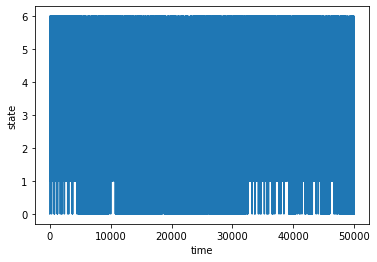

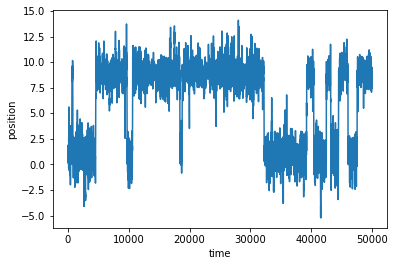

In [202]:
# let's plot the trajectory
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

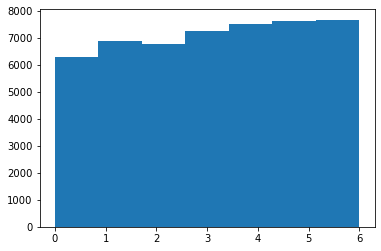

In [203]:
# now, nearly equal sampling of states!
plt.hist(itraj,bins=len(Ts))
plt.show()


In [204]:
energies = potentials[0](xtraj)

Let's try to calculate the expectations in energy at each temperature, using mixture reweighting. 

In [206]:
#rescaled energies for pymbar
reduced_energies = np.zeros([len(Ts),len(xtraj)])
for i,T in enumerate(Ts):
    reduced_energies[i,:] = energies/T

In [207]:
N_k = np.zeros(len(Ts))
for i in range(len(Ts)):
    N_k[i] = (itraj==i).sum() # count how many samples there are at each temperature
print(N_k)
mbar=pymbar.MBAR(reduced_energies,N_k,verbose=True)
results = mbar.compute_free_energy_differences()
results['Delta_f'][:,0]*Ts

[6286. 6871. 6783. 7246. 7526. 7621. 7667.]


array([  0.        ,  -1.52830807,  -3.94977701,  -7.8257442 ,
       -14.04626196, -23.71726486, -37.8893764 ])

We can use reweighting from all of the temperature states to compute averages at each of the states. Compare these to the analytical results.

In [208]:
mbar.compute_expectations(energies)

{'mu': array([-1.70744099, -1.22999005, -0.41467785,  0.79063256,  2.86029084,
         6.72819606, 13.96860182]),
 'sigma': array([0.00195671, 0.00477297, 0.00798052, 0.01343859, 0.02767876,
        0.06692967, 0.22116535])}

In [209]:
print('Average energy E[T] =',Es)

Average energy E[T] = [-1.71402758 -1.26159416 -0.46211716  0.75509062  2.88124067  6.95295316
 13.87973719]


Better agreeement!